# Conditional, observed conditional, and predictive power

## Preliminaries

In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(patchwork)
})

set.seed(42)
source("../R/util.R")
dir.create("../output/figures", recursive = TRUE, showWarnings = FALSE)

options(repr.plot.width = 12, repr.plot.height = 5)

Loading required package: renv


Attaching package: ‘renv’


The following object is masked from ‘package:stats’:

    update


The following objects are masked from ‘package:utils’:

    history, upgrade


The following objects are masked from ‘package:base’:

    load, remove




* The library is already synchronized with the lockfile.


$$
\newcommand{\Pr}{\operatorname{Pr}}
\newcommand{\CP}{\operatorname{CP}}
\newcommand{\OCP}{\operatorname{OCP}}
\newcommand{\PP}{\operatorname{PP}}
\newcommand{\PoS}{\operatorname{PoS}}
\newcommand{\crit}{z_{1-\alpha}}
\newcommand{\cond}{\,|\,}
$$

## Clinical trial example: initial sample size

We consider a single arm superiority trial to test $\mathcal{H}_0:\theta\leq 0$ based on the test statistic

$$
Z_n := \frac{1}{\sqrt{n}}\sum_{i=1}^n X_i, \quad \operatorname{E}[\,X_i\,] = \theta,\quad \operatorname{V}[\,X_i\,] = 1
$$

for independent and identically distributed $X_i$. 
All following considerations can easily be generalised to the practically more relevant two-arm superiority case. 
We merely discuss the single-arm case for the sake of simplicity in terms of notation.
The test statistic is asymptotically normal

$$
Z_n\stackrel{\cdot}{\sim}\mathcal{N}\big(\sqrt{n}\,\theta, 1\big) \ .
$$

We further assume that there is prior information that can be summarized in a truncated normal prior 

$$
\Theta \sim \mathcal{N}\big|_{[-0.5, 1]}\big(0.4, 0.2\big)
$$

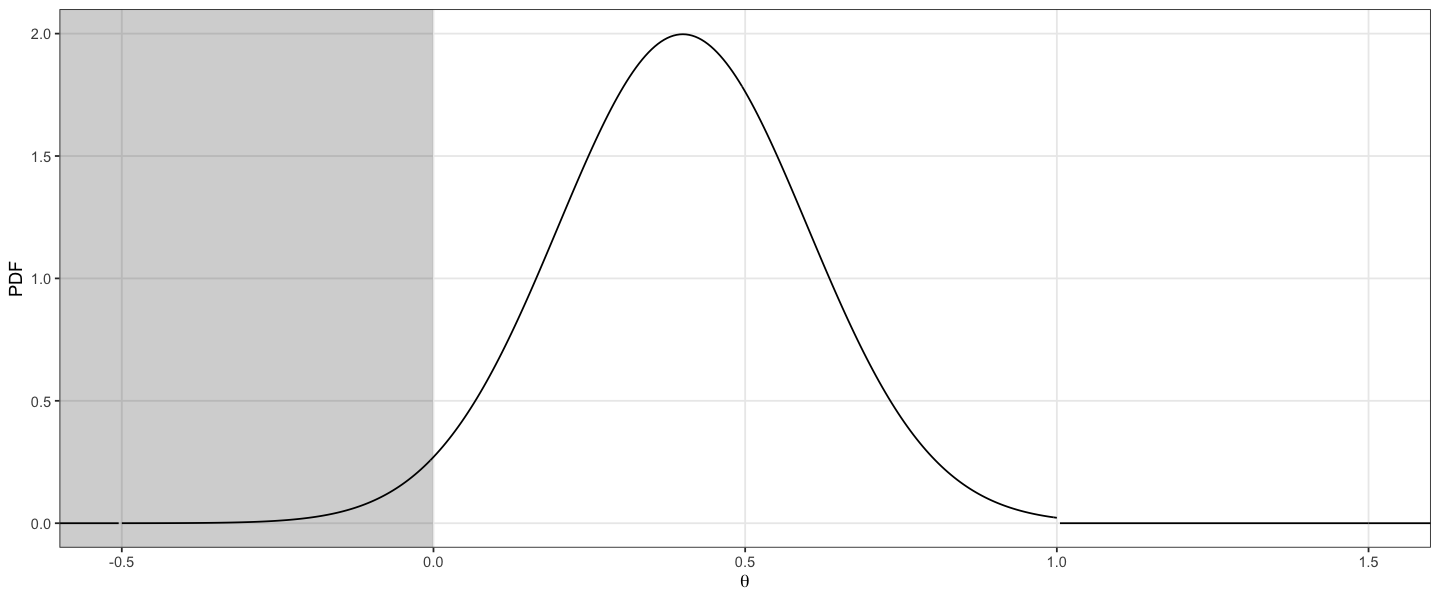

In [2]:
prior <- TruncatedNormal(mu = 0.4, tau = 0.2, a = -0.5, b = 1.0)

tibble(
    theta = seq(-1, 2, by = 0.005),
      PDF = map_dbl(theta, ~probability_density(prior, .))
) %>%
mutate(
    support = case_when(
            theta < -0.5 ~ 'left',
            theta >  1.0 ~ 'right',
                    TRUE ~ 'support'
        )
) %>% 
ggplot() +
    aes(theta, PDF, group = support) +
    annotate('rect', xmin = -10, xmax = 0, ymin = -10, ymax = 10, fill = 'black', alpha = 0.2) +
    geom_line() +
    theme_bw() + 
    labs(x = expression(theta)) +
    coord_cartesian(xlim = c(-0.5, 1.5), ylim = c(0, 2)) +
    theme(
        legend.position = 'top',
        panel.grid.minor = element_blank()
    )

In [3]:
ggsave("../output/figures/prior_density.pdf", width = 8, height = 3.5)

To dermine the sample size $n$, we assume that the maximal acceptable type one error rate is $\alpha=0.025$ and an expected power [???] of $1-\beta=0.8$ is targeted.

In [4]:
alpha <- 0.025
 crit <- qnorm(1 - alpha)

 beta <- 0.2

n <- 1
while (expected_power(n, crit, prior) < 1 - beta) {
    n <- n + 1
}
cat(sprintf("required n: %i, expected power: %6.2f", n, 100*expected_power(n, crit, prior)))

required n: 79, expected power:  80.07

## Unplanned interim analyses

We now consider a situation where - for whatever reason - an unblinded interim analysis is conducted after $m=26$ outcomes have been observed. [todo: how is that usually justified?]

The sponsor then wants to reassess the prospects of successfully rejecting the null hypothesis at the end if the trial. Mainly four quantities are discussed in the literature in this context. 

In [5]:
m <- 26

### Conditional power

We define conditional power as the probability to ultimately reject the
null hypothesis when $m < n$ outcomes are observed where $n$ is the final sample size

\begin{align}
\CP(z_m, \crit, \theta) :&= \Pr_\theta[\,Z_n > \crit \cond Z_m = z_m\,] \\
    &= 1 - \Phi\left(
            \frac{\crit - \sqrt{n}\,\theta - \sqrt{\tau} \, z_m + \sqrt{m}\,\theta
            }{\sqrt{1 - \tau}}
        \right) \ .
\end{align}

Note that the expression $\CP(z_m, \crit, \theta)$ depends on the unknown effect size $\theta$. 

### Assumed Conditional Power (ACP)

Often the sample size $n$ is not based on expected power but simply the power at a point alternative $\theta_1>0$.
Conditional power is then often used to synomously refer to $\CP(z_m, \crit, \theta_1)$ where the unknown effect size is simply replaced with the effect size underlying the sample size calculation. 
Although we derived $n$ using predictive power and the prior density $\varphi(\cdot)$, we can mimmic the process by plugging in the prior mean, $0.4$.
To make the distinction between $\CP(z_m, \crit, \theta)$ and $\CP(z_m, \crit, \theta_1)$ explicit, we refer to the latter one as 'assumed conditional power' or ACP. 

In [6]:
theta1 <- 0.4

### Observed conditional power

An alternative approach sometimes cited in the literature [The reassessment of trial perspectives from interimdata—a critical view] is to use the
maximum likelihood estimator for $\theta$, $\widehat{\theta}(z_m):=z_m/\sqrt{m}$, as plug-in.
We then define observed conditional power as
$$
\OCP(z_m, \crit) := \CP\big(z_m, \crit, \widehat{\theta}(z_m)\big) \ .
$$

### Predictive power

A more principled approach is given by simply conditioning expected power on the observed interim outcome $Z_m = z_m$.
This quantity has been termed predictive power in the literature although 'conditional expected power' might be a more fitting term. 
In contrast to most previous authors [???] we are consistent with [our paper] and conditiona on $\Theta>0$. 
Predictive power is thus defined as

\begin{align}
    \PP(z_m,\crit) :\!\!&= \Pr[\,Z_n > c \cond \Theta >0, Z_m = z_m\,] \\
    &= \int_{0}^{\infty}\CP(z_m, \crit, \theta)\,\frac{\varphi(\theta\cond Z_m=z_m)}{\Pr[\,\Theta\geq0\cond Z_m=z_n\,]}\operatorname{d}\theta \ .
\end{align}

## Comparing conditional-, observed-, predictive power, and conditional probability of success

Notes:
* predictive power directly relates to (unconditional) expected power [cite our paper] which is an attractive unconditional measure to generalise frequentist power (and sample size derivation) under uncertainty; in fact, predictive power is just expected power conditioned on the interim results.
* predictive power should be conditional on the existance of an effect [cite our paper]
* predictive power directly relates to the conditional probability of success; using it thus facilitates consistent discussion of early-futility stopping which should be based on the joint probability of a positive effect and its detection conditional on the interim data (condition probability of success).
* predictive power is actually a generalisation of conditional power; conditional power can be seen as a special case with a point prior on $\theta_1$; this shows that the use of conditional power implicitly makes strong assumptions.

We now compare the three quantities in more detail.
Firstly, we can assess how they change as functions of the interm observed outcome.

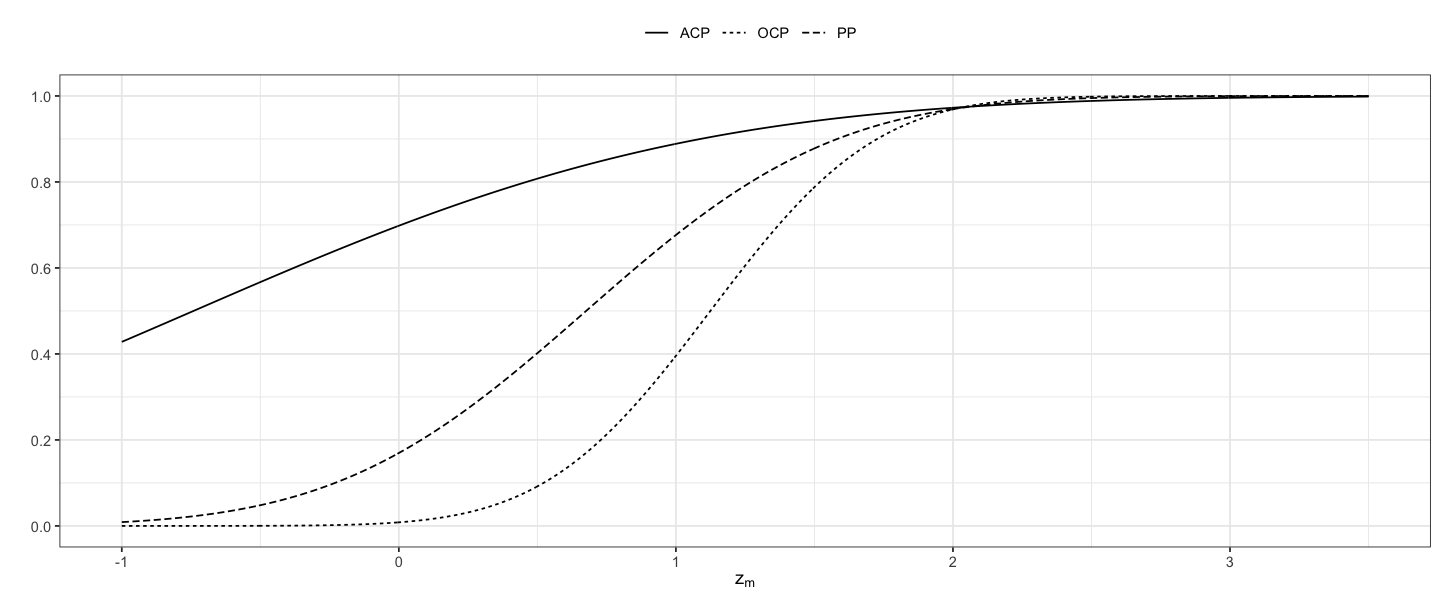

In [7]:
tibble(
      z = seq(-1, 3.5, by = 0.005),
    ACP = map_dbl(z, ~conditional_power(., m, n, crit, theta1)),
    OCP = map_dbl(z, ~observed_conditional_power(., m, n, crit)),
     PP = map_dbl(z, ~predictive_power(., m, n, crit, prior))
) %>% 
pivot_longer(-z, names_to = 'quantity') %>%
ggplot() +
    aes(z, value, linetype = quantity) +
    geom_line() +
    labs(x = expression(z[m]), y = '') +
    scale_y_continuous('', breaks = seq(0, 1, by = 0.2)) +
    scale_linetype('') +
    theme_bw() +
    theme(
        legend.position = 'top'
    )

In [8]:
ggsave("../output/figures/acp_ocp_pp_example.pdf", width = 8, height = 4.5)

One may also look at ACP, OCP, and PP from and estimation perspective. 
If the goal is to estimate the unknown $\CP(z_m, \crit, \theta)$, ACP, OCP, and PP can be seen as estimators. 
We can then compare them in terms of their precision, e.g., using the mean absolute error and bias.

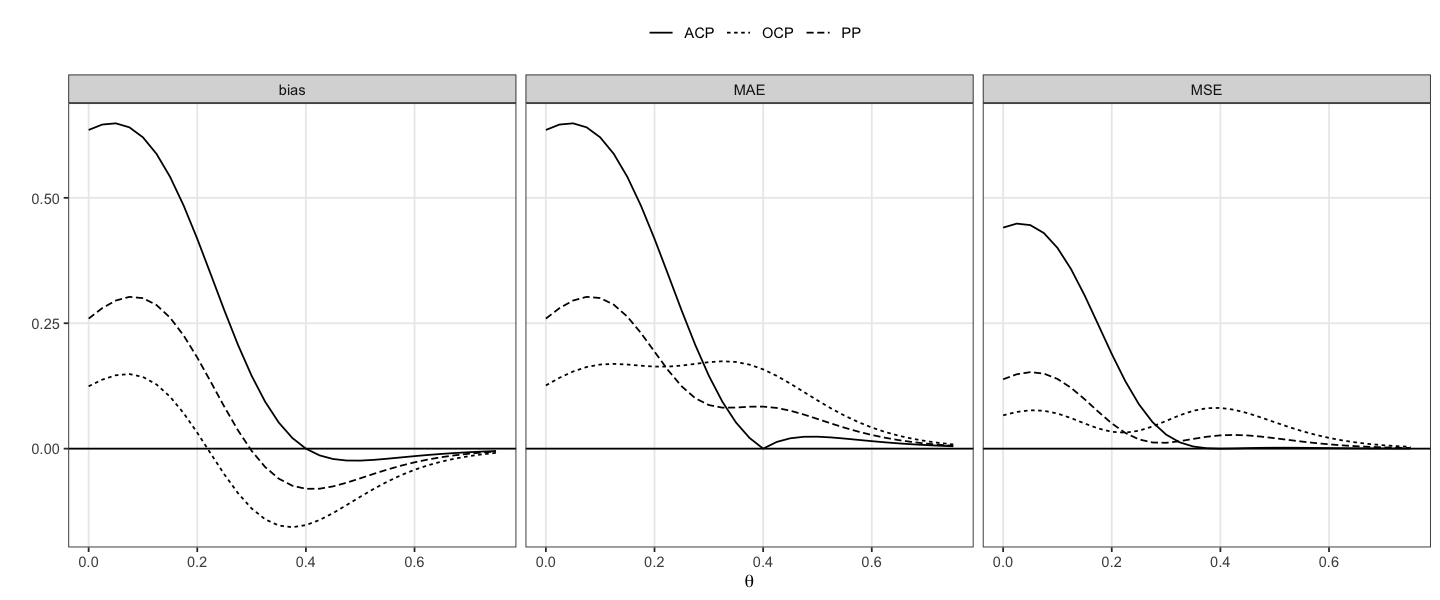

In [9]:
expand_grid(
    theta = seq(0, 0.75, by = 0.025),
       zm = rnorm(1000)
) %>% 
mutate(
       zm = zm + sqrt(m)*theta,
       CP = map2_dbl(zm, theta, ~conditional_power(..1, m, n, crit, ..2)),
      ACP =  map_dbl(zm, ~conditional_power(., m, n, crit, theta1)),
      OCP =  map_dbl(zm, ~observed_conditional_power(., m, n, crit)),
       PP =  map_dbl(zm, ~predictive_power(., m, n, crit, prior))
) %>% 
pivot_longer(c(ACP, OCP, PP)) %>%
group_by(theta, name) %>%
summarize(
    bias = mean(value - CP),
     MAE = mean(abs(value - CP)),
     MSE = mean((value - CP)^2),
    .groups = "drop"
) %>% 
pivot_longer(c(bias, MAE, MSE), names_to = "quantity") %>% 
ggplot() +
    aes(theta, value, linetype = name) +
    geom_hline(yintercept = 0) +
    geom_line() +
    facet_wrap(~quantity) +
    labs(x = expression(theta), y = '', color = '') +
    scale_linetype('') +
    theme_bw() + 
    theme(
         legend.position = 'top',
        panel.grid.minor = element_blank()
    )

In [10]:
ggsave("../output/figures/acp_ocp_pp_bias_mae_mse.pdf", width = 8, height = 4)

Clearly, the high sensitivity of OCP leads to a high but consistent MAE as cmpared to CP, which is very good close to the assumed parameter value but very bad for much smaller true values of $\theta$. Again,the Bayesian PP compromise between these extremes based on the properties of the prior.
Note that the MAE of ACP is better than that of OCP for a quite wide range of parameter values around the assumed $\theta=0.4$.

In terms of  maximal absolute bias, OCP is best, but in the relevant region even weak prior or a vague prior with wrong mean performs best. 

* CP, OCP, PP can be seen as estimators of unknown $\CP(z_m, \crit, \theta)$
* typically $m<<n$ will be small since a late change of sample size has little effect
* estmating $\theta$ is already hard after observing $n$ since the sample size is usually derived based on power arguments (80%/90%) and deciding weather or not to reject the null hypthesis is an easier problem than estimating the underlying parameter precisely
* $m<<n$ then means that the evidence on the magintude of $\theta$ during an early interim ins very sparse, i.e., the estimaton problem is even harder than at the end of the study
* the estimation problem can be stabilised using some form of regularistion and that is exactly what PP does via the Bayesian prior

## Sampling distribution of CP, OCP, PP

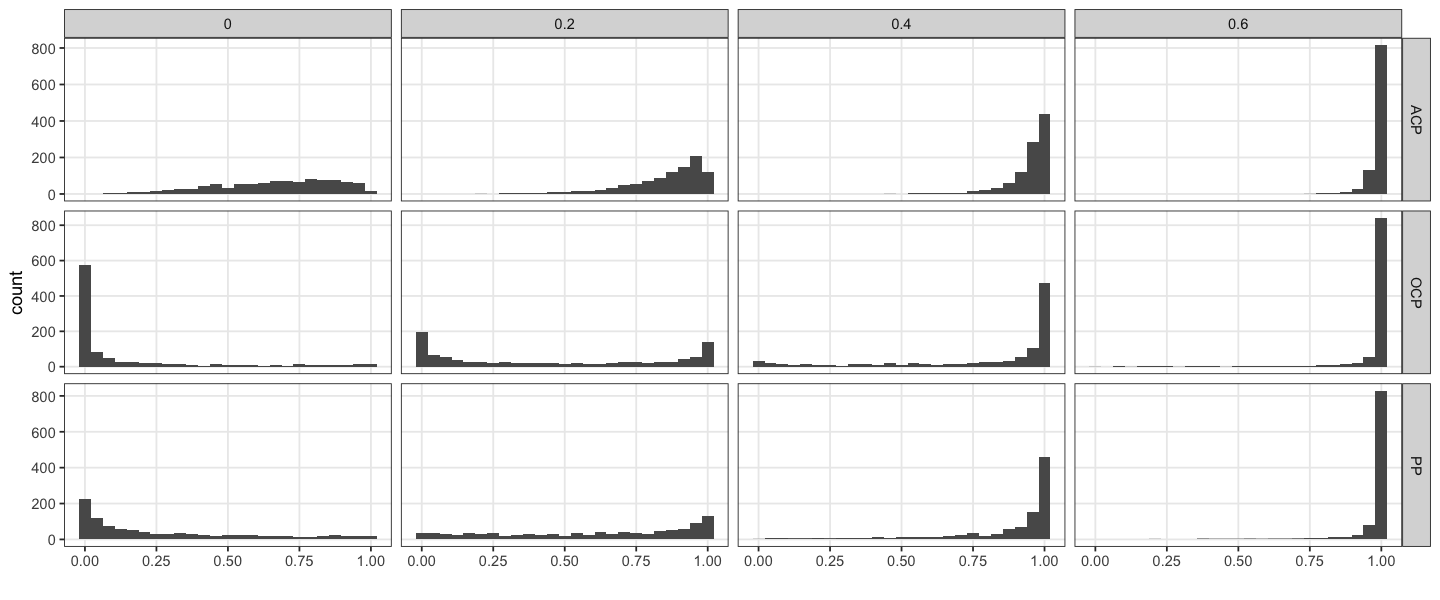

In [11]:
expand_grid(
    theta = seq(0, 0.6, by = 0.2),
       zm = rnorm(1000)
) %>% 
mutate(
       zm = zm + sqrt(m)*theta,
      ACP =  map_dbl(zm, ~conditional_power(., m, n, crit, theta1)),
      OCP =  map_dbl(zm, ~observed_conditional_power(., m, n, crit)),
       PP =  map_dbl(zm, ~predictive_power(., m, n, crit, prior))
) %>% 
pivot_longer(c(ACP, OCP, PP)) %>%
ggplot() +
    aes(value) +
    geom_histogram(bins = 25, position = 'identity') + 
    facet_grid(name ~ theta, scales = 'free_y') +
    theme_bw() +
    labs(x = "") +
    theme(
        panel.grid.minor = element_blank()
    )

In [12]:
ggsave("../output/figures/acp_ocp_pp_sampling_distributions.pdf", width = 8, height = 5)